In [65]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets
from pathlib import Path
import pandas as pd
from scipy.stats import binned_statistic_2d
from functions import *
import cartopy.crs as ccrs
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter
import numpy as np


In [66]:
output_folder = Path.cwd()/"output_plots"

# Import and read the dataframe from cn04 

In [67]:
cwd = Path.cwd()
filename = cwd / "/Users/alexisheitzmann/Documents/CHEOPS/Code/SAA_monitoring_MC/CheopsCosmics/data_2023_06_24_to_2023_07_02.pkl"
data_file = Path(filename)

all_data = pd.read_pickle(data_file)

# Functions

In [68]:
def plot_function(data_to_plot, title):
    
    def plotimg(idx):
        # Update histogram
        ax[0].clear()
        ax[0].hist(data_to_plot[int(idx)].flatten(), bins = len(np.unique(data_to_plot[int(idx)].flatten())))
        # Update image
        img.set_data(data_to_plot[int(idx),:,:])
        im = ax[1].imshow(data_to_plot[int(idx),:,:], origin='lower', cmap = 'viridis')
        ax[0].axvline(np.nanmedian(data_to_plot[int(idx),:,:]), c = 'r',  alpha = 0.5) # median pixel value
        ax[0].axvline(np.nanmean(data_to_plot[int(idx),:,:]), c = 'g', alpha = 0.5) # mean pixel value
        #plt.colorbar(im)
        fig.canvas.draw_idle()
        
    fig, ax = plt.subplots(ncols = 2, figsize=(12,4))
    img = ax[1].imshow(data_to_plot[0], origin='lower')
    #colorbar = plt.colorbar(img)
    ax[0].set_xlabel('Brightness')
    ax[0].set_ylabel('Nb of pixels')
    plt.suptitle(title, weight = 'bold')

    ipywidgets.interact(plotimg, idx = ipywidgets.FloatSlider(value=0,min=0,max=np.shape(data_to_plot)[0]-1,step=1))
    plt.show()
    
def apply_filters(data, filter_names, values, reverse_filters):
    
    # Available filters ['latitude-','latitude+','visit','density_cosmics','nb_cosmics','no_straylight','largest_cosmics','percentage_cosmics']
    list_filter_names = ['time-','time+','latitude-','latitude+','visit','density_cosmics','nb_cosmics','no_straylight','largest_cosmics','percentage_cosmics']
    
    filtered_data = data.copy()
    
    for filter_name, value, reverse in zip(filter_names,values, reverse_filters): 
        
        if reverse:
            inf = '>'
            sup = '<'
        else: 
            inf = '<'
            sup = '>'
            
        if filter_name == 'time-':
            print(f"Keep data {sup} {value}")
            filter_to_apply = filtered_data['time'] >= value
        elif filter_name == 'time+':
            print(f"Keep data {inf} {value}")
            filter_to_apply = filtered_data['time'] <= value
        elif filter_name == 'latitude-':
            print(f"Kepp data with latitude {sup} {value}")
            filter_to_apply = filtered_data['LATITUDE'] > value
        elif filter_name == 'latitude+':
            print(f"Keep with latitude {inf} {value}")
            filter_to_apply = filtered_data['LATITUDE'] < value  
        elif filter_name == 'visit':
            print(f"Keep data only from {value}")
            filter_to_apply = filtered_data['visit_ID'] == value
        elif filter_name == 'density_cosmics':
            print(f"Keep data only with a density of cosmics {sup} {value}")
            filter_to_apply = filtered_data['density_cosmics'] > value        
        elif filter_name == 'nb_cosmics':
            print(f"Keep data only with a number of cosmics {sup} {value}")
            filter_to_apply = filtered_data['nb_cosmics'] > value        
        elif filter_name == 'no_straylight':
            if reverse:
                print(f"Keep data only affected with straylight")
            else:
                print(f"Keep data only not affected with straylight")
            filter_to_apply = filtered_data['straylight_boolean']
            filter_to_apply = ~filter_to_apply
        elif filter_name == 'largest_cosmics':
            print(f"Keep data only with a largest cosmic {inf} {value}")
            filter_to_apply = filtered_data['largest_cosmics'] < value
        elif filter_name == 'percentage_cosmics':
            print(f"Keep data images with {inf} {value}% of pixels affected by cosmics")
            filter_to_apply = filtered_data['percentage_cosmics'] < value
        else:
            print(f"{filter_name} not in {list_filter_names}")   
            
        # apply filter 
        if reverse:
            filter_to_apply = ~filter_to_apply

        nb_points = len(filtered_data)
        filtered_data = filtered_data[filter_to_apply]
        nb_datapoints_remomoved =  nb_points - len(filtered_data)
        print(f"Removed {nb_datapoints_remomoved} data points, kept {len(filtered_data)}")
        
    return filtered_data

def bin_data(x,y,c,interpolation = 'None', type = None):
    
    # Bin and maks SAA mask contour
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -90, 90

    # interpolation can be 'None, 'base_grid' or 'fine_grid'
    
    from scipy.interpolate import RBFInterpolator
    bin_size = 5
    x_bins = np.arange(lon_min+bin_size, lon_max, bin_size)
    y_bins = np.arange(lat_min+bin_size, lat_max, bin_size)
    
    # bin
    ret = binned_statistic_2d(x, y, c, statistic='median', bins=[x_bins, y_bins])

    # Get the array of bin values and the bin edges
    statistic = ret.statistic.T
    x_edges = ret.x_edge
    y_edges = ret.y_edge

    # Compute the bin centers
    bin_centers_x = (x_edges[:-1] + x_edges[1:]) / 2
    bin_centers_y = (y_edges[:-1] + y_edges[1:]) / 2
    X, Y = np.meshgrid(bin_centers_x, bin_centers_y)

    # Flatten the arrays for easier indexing
    points = np.column_stack([X.ravel(), Y.ravel()])
    values = statistic.ravel()

    # Remove NaN values from the points and values
    mask = ~np.isnan(values)
    valid_points = points[mask]
    valid_values = values[mask]

    # Define a finer grid for finer interpolation
    nb_points_finer_grid = 200
    finer_x = np.linspace(bin_centers_x.min(), bin_centers_x.max(), nb_points_finer_grid)  # More points
    finer_y = np.linspace(bin_centers_y.min(), bin_centers_y.max(), nb_points_finer_grid)  # More points
    Finer_X, Finer_Y = np.meshgrid(finer_x, finer_y)

    # Flatten the finer grid for interpolation
    finer_points = np.column_stack([Finer_X.ravel(), Finer_Y.ravel()])

    # Use the same valid_points and valid_values from the previous example
    interpolator = RBFInterpolator(valid_points, valid_values, kernel='linear', smoothing = 0)
    
    # Interpolate
    if interpolation == 'None':
        print("No interpolation")
        statistic = ret.statistic.T
        lon_mesh = None
        lat_mesh = None
    elif interpolation == 'base_grid':
        print(f"Interpolating on the {bin_size} degrees grid")
        values = interpolator(points)
        statistic = values.reshape(X.shape)
        lon_mesh = X
        lat_mesh = Y
    elif interpolation == 'fine_grid':
        print(f"Interpolating on a finer grid")
        finer_values = interpolator(finer_points)
        statistic = finer_values.reshape(Finer_X.shape)
        lon_mesh = Finer_X
        lat_mesh = Finer_Y
    if type == 'density_cosmics':
        # set low values to 1
        mask_low_values = statistic < 1
        statistic[mask_low_values] = 1
    elif type == 'percentage_cosmics':
        # set low values to 0.01
        mask_low_values = statistic < 0.01
        statistic[mask_low_values] = 0.01
    else:
        print("Please set type to convert low values, convertion ignored")
        pass
    
    
    return statistic, bin_centers_x, bin_centers_y, lon_mesh, lat_mesh

def circle_points(lat, lon, radius, num_points=100):
    """
    Calculate the latitude and longitude points that form a circle of given radius
    centered on a given latitude and longitude.

    :param lat: Latitude of the center in degrees
    :param lon: Longitude of the center in degrees
    :param radius: Radius of the circle in degrees (approx. for small circles)
    :param num_points: Number of points to generate along the circle
    :return: Two numpy arrays (lats, lons) representing the circle's latitude and longitude points
    """
    # Convert radius from degrees to radians
    radius_rad = np.deg2rad(radius)

    # Generate equally spaced angles around the circle
    angles = np.linspace(0, 2 * np.pi, num_points)

    # Calculate the latitude and longitude points
    latitudes = np.arcsin(np.sin(np.deg2rad(lat)) * np.cos(radius_rad) +
                          np.cos(np.deg2rad(lat)) * np.sin(radius_rad) * np.cos(angles))
    
    longitudes = np.deg2rad(lon) + np.arctan2(np.sin(angles) * np.sin(radius_rad) * np.cos(np.deg2rad(lat)),
                                               np.cos(radius_rad) - np.sin(np.deg2rad(lat)) * np.sin(latitudes))
    
    # Convert the latitude and longitude from radians to degrees
    latitudes = np.rad2deg(latitudes)
    longitudes = np.rad2deg(longitudes)
    
    sort_lon = np.argsort(longitudes)

    return latitudes[sort_lon], longitudes[sort_lon]

# Detections

In [69]:
if len(np.unique(all_data['im_height'])) > 1:
    diff_image_types = True # We have different image sizes in all_data
    print(f"Sizes available are {np.unique(all_data['im_height'])}")
else:
    diff_image_types = False

## Filter images

In [70]:
# DETECTIONS 
detections = all_data[all_data['nb_cosmics'] != 0]
#detections = all_data[(all_data['density_cosmics'] < 60) & (all_data['density_cosmics'] > 40)]
non_detections = all_data[all_data['nb_cosmics'] == 0]

max_cosmics = np.max(detections['nb_cosmics'])
max_density = np.max(detections['density_cosmics'])

print(f'Frame with most cosmics has {max_cosmics} cosmics. largest density is {int(max_density)} hits/cm2/sec')
print(f"{int(len(detections)/len(all_data)*100)}% of visits ({len(detections)}/{len(all_data)}) have detections. {int(len(non_detections))} non detections\n")

# separate different images sizes
if diff_image_types:
    size_to_keep = 100
    detections_plot = detections[detections['im_height'] == size_to_keep]
    non_detections_plot = non_detections[non_detections['im_height'] == size_to_keep]
    print(f"!! Only images of sizes {size_to_keep}*{size_to_keep} are shown !!\n")
else:     
    detections_plot = detections
    non_detections_plot = non_detections
    
## Add other filters 
# Available filters ['latitude-','latitude+','visit','density_cosmics','nb_cosmics','no_straylight','largest_cosmics', 'percentage_cosmics']
filters = ['no_straylight']#,'percentage_cosmics']#,'largest_cosmics']#,'percentage_cosmics','percentage_cosmics']
values = [0.05]#,0.3]#,1000]
reverse_filters = [True]#, False]

print("DETECTIONS:")
detections_plot = apply_filters(detections_plot,filters,values,reverse_filters)
print("")
print("NON DETECTIONS:")
non_detections_plot = apply_filters(non_detections_plot,filters,values,reverse_filters)
print("")
print("ALL DATA:")
all_data_filtered = apply_filters(all_data,filters,values,reverse_filters)

Frame with most cosmics has 672 cosmics. largest density is 471 hits/cm2/sec
60% of visits (3792/6232) have detections. 2440 non detections

DETECTIONS:
Keep data only affected with straylight
Removed 3258 data points, kept 534

NON DETECTIONS:
Keep data only affected with straylight
Removed 2357 data points, kept 83

ALL DATA:
Keep data only affected with straylight
Removed 5615 data points, kept 617


visit:10_12_39_1 not here
Keep data only from 10_18_403_3
Removed 6003 data points, kept 229


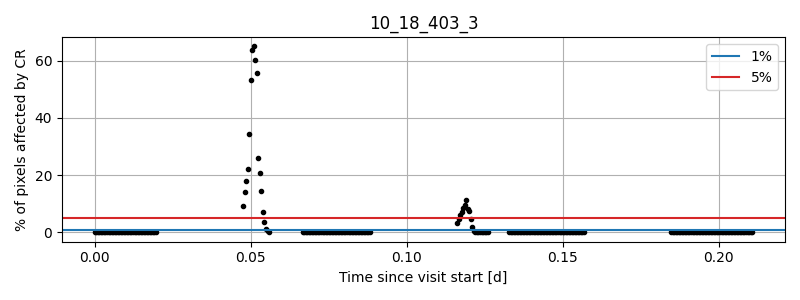

visit:10_18_437_2 not here
visit:10_18_442_3 not here
visit:10_18_497_5 not here
visit:10_18_498_4 not here
visit:10_18_525_2 not here
visit:10_24_163_1 not here
Keep data only from 10_25_81_1
Removed 5671 data points, kept 561


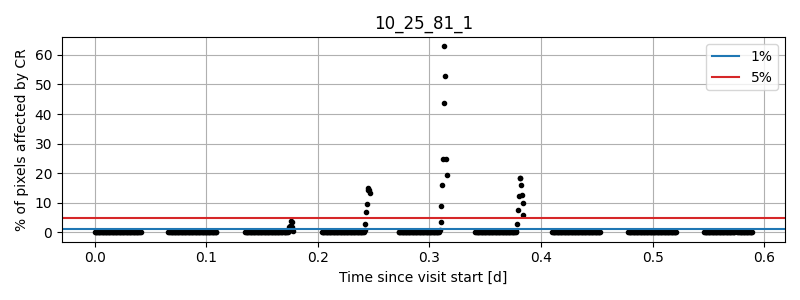

Keep data only from 13_57_37_10
Removed 5813 data points, kept 419


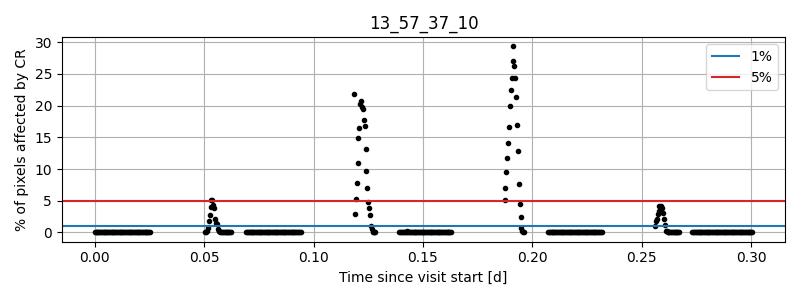

Keep data only from 13_57_37_9
Removed 5955 data points, kept 277


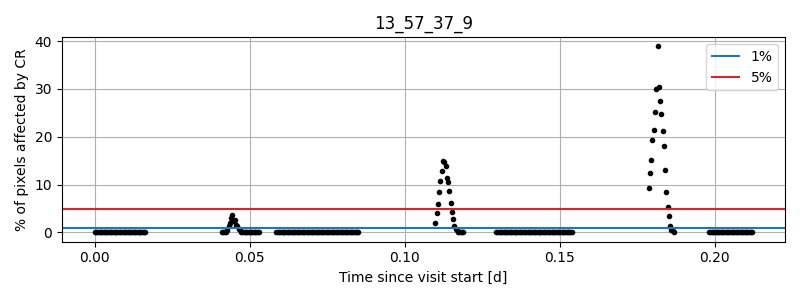

Keep data only from 14_63_14_3
Removed 5863 data points, kept 369


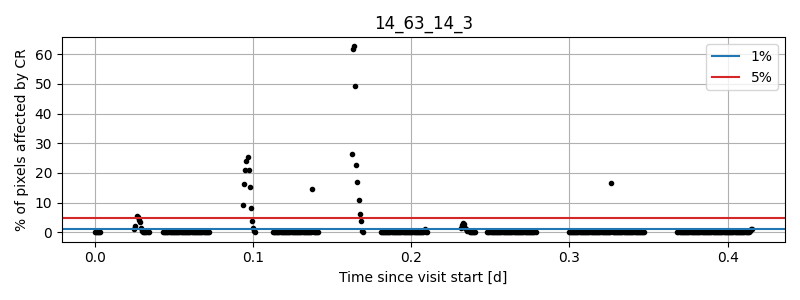

Keep data only from 14_63_14_4
Removed 5920 data points, kept 312


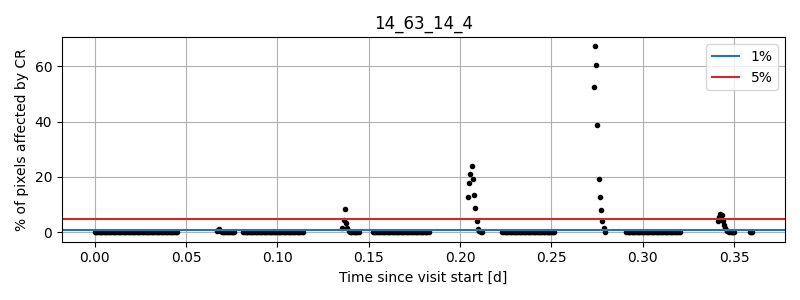

visit:14_66_4_2 not here
visit:14_66_4_3 not here
Keep data only from 14_71_8_3
Removed 6042 data points, kept 190


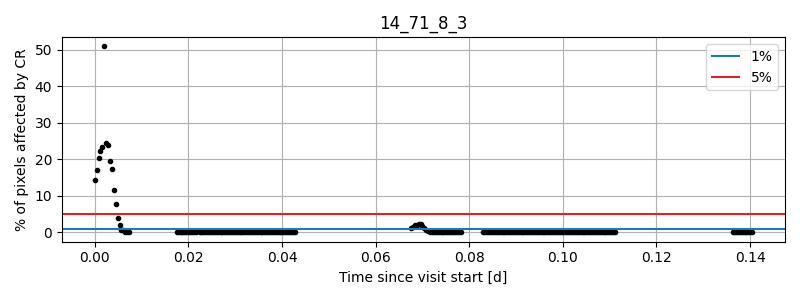

visit:14_76_1_4 not here
visit:14_76_1_5 not here
visit:14_79_2_1 not here
visit:14_80_10_2 not here
visit:14_80_12_1 not here
Keep data only from 14_84_23_1
Removed 5610 data points, kept 622


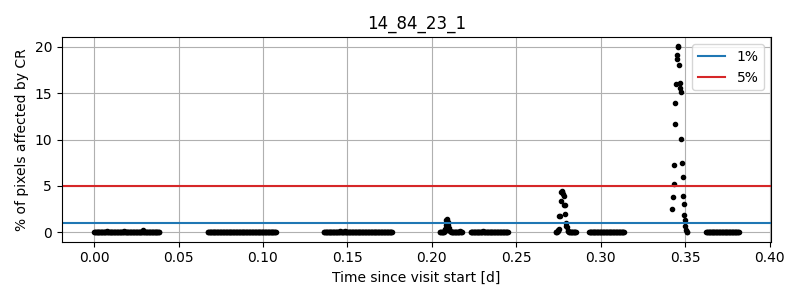

Keep data only from 14_84_23_2
Removed 5624 data points, kept 608


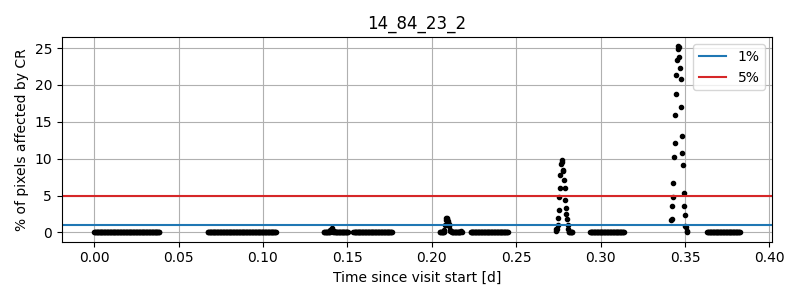

In [71]:
affected_visits = np.array(['10_12_39_1', '10_18_403_3', '10_18_437_2',
       '10_18_442_3', '10_18_497_5', '10_18_498_4', '10_18_525_2',
       '10_24_163_1', '10_25_81_1', '13_57_37_10', '13_57_37_9',
       '14_63_14_3', '14_63_14_4', '14_66_4_2', '14_66_4_3',
       '14_71_8_3', '14_76_1_4', '14_76_1_5', '14_79_2_1', '14_80_10_2',
       '14_80_12_1', '14_84_23_1', '14_84_23_2'])

for visit in affected_visits:
    
    if len(all_data[all_data.visit_ID == visit]) == 0:
        print(f'visit:{visit} not here')
        continue

    ## Add other filters 
    # Available filters ['latitude-','latitude+','visit','density_cosmics','nb_cosmics','no_straylight','largest_cosmics', 'percentage_cosmics']
    filters = ['visit']#,'largest_cosmics']#,'percentage_cosmics','percentage_cosmics']
    values = [visit]#, 150]#,1,100]
    reverse_filters = [ False]#,False]
    data_visit = apply_filters(all_data,filters,values,reverse_filters)

    plt.figure(figsize = (8,3))
    time_since_visit_start = data_visit.index-data_visit.index[0]
    plt.plot(time_since_visit_start,data_visit.percentage_cosmics, 'k.')
    # straylight_points = data_visit[data_visit.straylight_boolean]
    # time_since_visit_start_stray = time_since_visit_start[data_visit.straylight_boolean]
    # plt.plot(time_since_visit_start_stray,straylight_points.percentage_cosmics, 'r.')
    plt.axhline(1, color = 'C0',label= '1%')
    plt.axhline(5, color = 'C3',label = '5%')
    plt.title(np.unique(data_visit.visit_ID)[0])
    plt.ylabel('% of pixels affected by CR')
    plt.xlabel('Time since visit start [d]')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig('CR percentage.png', format = 'png', dpi = 600)
    plt.show()

# Plot detections and non-detections

interactive(children=(FloatSlider(value=0.0, description='idx', max=616.0, step=1.0), Output()), _dom_classes=…

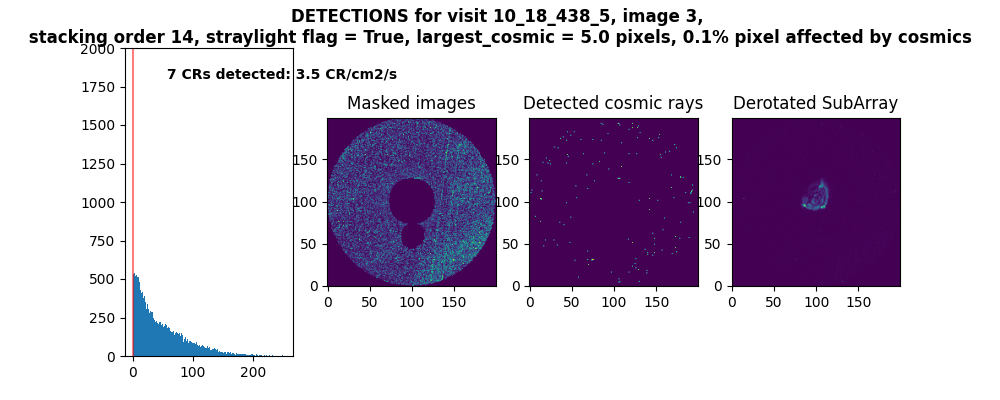

In [72]:
detection = True # If False --> non_detections

if detection:
    str_title = 'DETECTIONS'
    data = detections_plot
elif ~detection:
    str_title = 'NON DETECTIONS'
    data = non_detections_plot
else:
    str_title = 'ALL DATA'


data = all_data_filtered  


data_to_plot1 = reshape_flatten_images('masked_images', data) 
data_to_plot2 = reshape_flatten_images('binary_images', data) 
data_to_plot3 = reshape_flatten_images('derotated_images', data) 
# data_to_plot4 = reshape_flatten_images('raw_images', data)
visit_id = data['visit_ID'].values
stacking_order = data['n_exp'].values
image_counter = data['img_counter'].values
threshold_cosmics = data['threshold_cosmics'].values
cosmics = data['nb_cosmics'].values
density_cosmics = data['density_cosmics'].values
straylight_boolean = data['straylight_boolean'].values
largest_cosmics = data['largest_cosmics'].values
percentage_cosmics = data['percentage_cosmics'].values

def plotimg(idx):
    
    # Update histogram
    ax[0].clear()
    ax[0].hist(data_to_plot1[int(idx)].flatten(), bins = 255)#int(np.max(data_to_plot1[int(idx)].flatten())))
    #ax[0].set_xlim(0,100)
    ax[0].set_ylim(0,2000)
    # Update image
    img1.set_data(data_to_plot1[int(idx)])
    img2.set_data(data_to_plot2[int(idx)])
    img3.set_data(data_to_plot3[int(idx)])
    ax[1].imshow(data_to_plot1[int(idx)], origin='lower', cmap = 'viridis')
    ax[2].imshow(data_to_plot2[int(idx)], origin='lower', cmap = 'viridis')
    ax[3].imshow(data_to_plot3[int(idx)], origin='lower', cmap = 'viridis')
    # ax[4].imshow(data_to_plot4[int(idx)], origin='lower', cmap = 'viridis')
    ax[0].axvline(threshold_cosmics[int(idx)], c = 'r',  alpha = 0.5) # median pixel value
    ax[0].text(0.25,0.9,f'{int(cosmics[int(idx)])} CRs detected: {np.round(density_cosmics[int(idx)],1)} CR/cm2/s', weight = 'bold', transform=ax[0].transAxes)
    fig.suptitle(f'DETECTIONS for visit {visit_id[int(idx)]}, image {image_counter[int(idx)]}, \n stacking order {stacking_order[int(idx)]}, straylight flag = {straylight_boolean[int(idx)]}, largest_cosmic = {largest_cosmics[int(idx)]} pixels, {np.round(percentage_cosmics[int(idx)],1)}% pixel affected by cosmics ', weight = 'bold')
    #plt.colorbar(im)
    fig.canvas.draw_idle()
    
fig, ax = plt.subplots(ncols = 4, figsize=(10,4))
img1 = ax[1].imshow(data_to_plot1[0], origin='lower')
ax[1].set_title('Masked images')
img2 = ax[2].imshow(data_to_plot2[0], origin='lower')
ax[2].set_title('Detected cosmic rays')
img3 = ax[3].imshow(data_to_plot3[0], origin='lower')
ax[3].set_title('Derotated SubArray')
#colorbar = plt.colorbar(img)
# img4 = ax[4].imshow(np.exp(data_to_plot4[0]), origin='lower')
# ax[4].set_title('Original images')

ax[0].set_xlabel('Brightness')
ax[0].set_ylabel('Nb of pixels')

fig.suptitle(f"DETECTIONS for visit {visit_id[0]}, image {image_counter[0]}, \n stacking order {stacking_order[0]}", weight = 'bold')
ipywidgets.interact(plotimg, idx = ipywidgets.FloatSlider(value=0,min=0,max=np.shape(data_to_plot1)[0]-1,step=1))
plt.show()

# Inspect latitude and longitude

In [ ]:
# if type_of_visit == 'SAA':
#     resituted_orbit = pd.read_pickle('/Users/alexisheitzmann/Documents/CHEOPS/Code/SAA_monitoring_MC/restituted_orbit.pkl')
#     fig, ax = plt.subplots(ncols = 2, figsize=(12,4))
#     ax[0].plot(resituted_orbit.index,resituted_orbit['LATITUDE'], '.', label = 'restituted orbit')
#     ax[0].plot(detections.index,detections['LATITUDE'], '.', label = 'imagettes')
#     ax[0].set_title('LATITUDE')
#     ax[1].plot(resituted_orbit.index,resituted_orbit['LONGITUDE'], '.', label = 'restituted orbit')
#     ax[1].plot(detections.index,detections['LONGITUDE'], '.', label = 'imagettes')
#     ax[1].set_title('LONGITUDE')
# else:
#     print('science visits, no interpolation of orbit')

# MAP

In [79]:
map_data = all_data.copy()

projection = ccrs.PlateCarree(-50)
# projection = ccrs.Orthographic(0, -90) # South Pole
# projection = ccrs.Orthographic(0, 90) # North Pole
# projection = ccrs.Orthographic(-42, -26) # SAA_center
color_map = 'hot_r'
figsize = (12, 8)

south_mag_pole_coord = [107.3,-80.7] # from 2020, geomagnetic south pole 
north_mag_pole_coord = [-72.7,80.7] # from 2020, geomagnetic south pole 
# projection = ccrs.Orthographic(south_mag_pole_coord[0],south_mag_pole_coord[1]) # South Pole

## APPLY FILTER TO DATA ##
# Custom filters

# Keep only SAA visits 
start_AO1 = pd.Timestamp("2020-02-01 12:00:00", tz = 'UTC')
start_AO2 = pd.Timestamp("2021-03-26 12:00:00", tz = 'UTC')
start_AO3 = pd.Timestamp("2022-07-01 12:00:00", tz = 'UTC')
start_AO4 = pd.Timestamp("2023-09-25 12:00:00", tz = 'UTC')
start_AO5 = pd.Timestamp("2024-10-01 12:00:00", tz = 'UTC')
start_LTAN = pd.Timestamp("2023-09-21 12:00:00", tz = 'UTC') # start of LTAN campaign
end_LTAN = pd.Timestamp("2023-12-20 12:00:00", tz = 'UTC') # end of LTAN campaign

# map_data = map_data[map_data.visit_ID.str[:2] == '34']
start_date = pd.Timestamp("2023-04-20 00:00:00", tz = 'UTC')
end_date = pd.Timestamp("2023-07-15 00:00:00", tz = 'UTC')


# start_date = pd.Timestamp("2023-05-07 00:00:00", tz = 'UTC') # start of LTAN campaign
# end_date = pd.Timestamp("2023-05-11 00:00:00", tz = 'UTC') # end of LTAN campaign

# start_date = all_data.time.min()
# end_date = all_data.time.max()


# filters = ['time-','time+','no_straylight','largest_cosmics']
# values = [ç None, 100]
# reverse_filters = [False, False, False, False]
# map_data = apply_filters(map_data,filters,values,reverse_filters)

filters = ['no_straylight']#,'latitude-','latitude+']#,'no_straylight','largest_cosmics','percentage_cosmics']
values = [0]#,300]#,-45,-10]#,None, 150, 17]
reverse_filters = [False, False, False]#,False, False]#, False]
map_data = apply_filters(map_data,filters,values,reverse_filters)

nb_visits = len(np.unique(map_data.visit_ID))
nb_SAA_visits = len(np.unique(map_data[map_data.visit_ID.str[:6] == '34_102'].visit_ID))

print(f"\nVisits go from {start_date.strftime('%d-%b-%Y')} to {end_date.strftime('%d-%b-%Y')}")
print(f"There are {nb_visits} in total, including {nb_SAA_visits} SAA visits")

data_plot = map_data

x_values = 'LONGITUDE'
y_values ='LATITUDE'
# hue_values = 'density_cosmics'
hue_values = 'percentage_cosmics'


Keep data only not affected with straylight
Removed 617 data points, kept 5615

Visits go from 20-Apr-2023 to 15-Jul-2023
There are 16 in total, including 0 SAA visits


### SAA Data

In [80]:
# Read SAA mask

SAA_file = Path("ref_files") / "CH_TU2024-01-16T15-06-00_EXT_APP_SAAMap-690km_V0301.fits" # post-LTAN

data_SAA = read_SAA_map(SAA_file)

# Plot SAA mask
x = data_SAA['longitude']
y = data_SAA['latitude']
c = data_SAA['SAA_FLAG']

# Bin and maks SAA mask contour
lon_min, lon_max = -180, 180
lat_min, lat_max = -90, 90
    
SAA_map_bins_lon = 3
SAA_map_bins_lat = 2
x_bins_SAA = np.arange(lon_min + SAA_map_bins_lon, lon_max,SAA_map_bins_lon)
y_bins_SAA = np.arange(lat_min + SAA_map_bins_lat, lat_max,SAA_map_bins_lat)

SAA_masked_binned = binned_statistic_2d(x, y, c, statistic='median', bins=[x_bins_SAA, y_bins_SAA]).statistic.T
lon, lat = np.meshgrid(x_bins_SAA, y_bins_SAA)

In [81]:
SAA_file_old = Path("ref_files") / "CH_TU2020-03-11T00-00-00_EXT_APP_SAAMap-700km_V0102.fits" # pre-LTAN


data_SAA_old = read_SAA_map(SAA_file_old)

# Plot SAA mask
x_old = data_SAA_old['longitude']
y_old = data_SAA_old['latitude']
c_old = data_SAA_old['SAA_FLAG']

# Bin and maks SAA mask contour
lon_min, lon_max = -180, 180
lat_min, lat_max = -90, 90
    
SAA_map_bins_lon = 3
SAA_map_bins_lat = 2
x_bins_SAA_old = np.arange(lon_min + SAA_map_bins_lon, lon_max,SAA_map_bins_lon)
y_bins_SAA_old = np.arange(lat_min + SAA_map_bins_lat, lat_max,SAA_map_bins_lat)

SAA_masked_binned_old = binned_statistic_2d(x_old, y_old, c_old, statistic='median', bins=[x_bins_SAA_old, y_bins_SAA_old]).statistic.T
lon_old, lat_old = np.meshgrid(x_bins_SAA_old, y_bins_SAA_old)

### Map plot

Interpolating on the 5 degrees grid


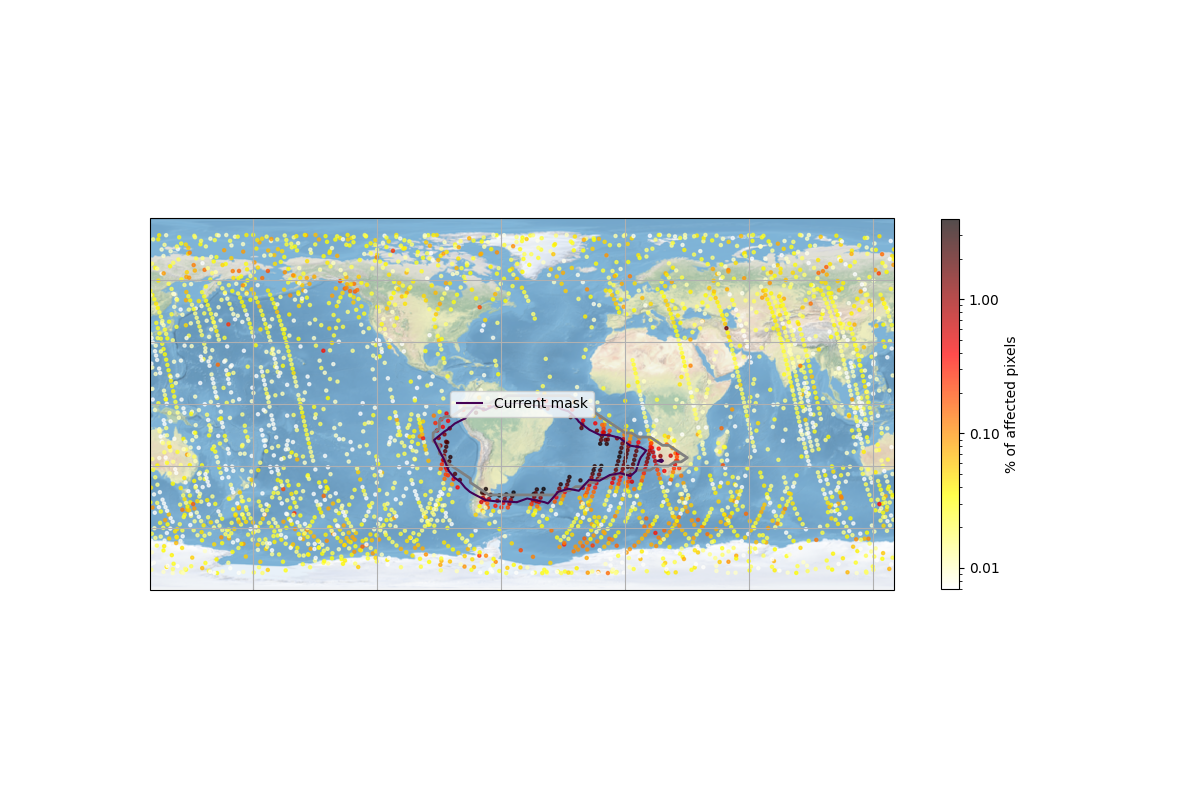

In [82]:
#%matplotlib widget
plt.close('all')
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=projection)

ax.stock_img()
ax.gridlines()


# Plot SAA contour
SAA_current = plt.contour(lon[1:,1:], lat[1:,1:], SAA_masked_binned, colors = 'grey', linewidths = 2,  alpha = 1,levels=[0], origin='lower', extent=(lon_min, lon_max, lat_min, lat_max),transform=ccrs.PlateCarree())
SAA_current = plt.contour(lon[1:,1:], lat[1:,1:], SAA_masked_binned, levels=[1], origin='lower', extent=(lon_min, lon_max, lat_min, lat_max),transform=ccrs.PlateCarree())
h3,_ = SAA_current.legend_elements()
plt.legend([h3[0]], ['Current mask'])

x = data_plot[x_values]
y = data_plot[y_values]
c = data_plot[hue_values]

binned_data, _, _, lon_data, lat_data  = bin_data(x,y,c, interpolation='base_grid', type = hue_values)
   
plt.contour(lon_data, lat_data, binned_data, levels=[1], origin='lower', extent=(lon_min, lon_max, lat_min, lat_max),transform=ccrs.PlateCarree())


SAA_map_plot = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, marker = 'o', norm=LogNorm(), cmap=color_map, transform=ccrs.Geodetic())#, label = labels[i])
# SAA_map_plot = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, marker = 'o', cmap=color_map, transform=ccrs.Geodetic())#, label = labels[i])

# SAA_map_plot = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, transform=ccrs.PlateCarree()) 
#SAA_map_plot = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, norm = LogNorm(), transform=ccrs.PlateCarree()) 

# SAA_map_plot = plt.scatter(x,y,c = c, s = 5, alpha = 0.7, marker = 'o', norm = LogNorm(), cmap=color_map, transform=ccrs.Geodetic())#, label = labels[i])
# SAA_map_plot = plt.scatter(x,y,c = c, s = 5, alpha = 0.7, marker = 'o',cmap=color_map, transform=ccrs.Geodetic())#, label = labels[i])

if hue_values == 'percentage_cosmics':
    cbar = plt.colorbar(SAA_map_plot, label = '% of affected pixels', shrink=0.6)
    cbar.formatter = FormatStrFormatter("%.2f")
    cbar.update_ticks()
else:
    cbar = plt.colorbar(SAA_map_plot, label = 'hits/cm2/s', shrink=0.6)

# #plt.title('June 28th, at 08:40:00, SAA_FLAG is False in MPS_PRE_VISIT')
# #plt.legend(frameon=True,bbox_to_anchor=(0.7,0),markerscale=1)
# #save_folder = '/Users/alexisheitzmann/Documents/CHEOPS/Code/SSA_mismapping/imagette_mapping/AU_Mic_5_sec_visits/'
# name_addition = 'all'
# save_name = 'map_CR_detections_'+ name_addition + '_' + np.min(full_orb_res_err.index).strftime("%Y-%m-%d") + '_to_' + np.max(full_orb_res_err.index).strftime("%Y-%m-%d") + '.png'
#title = str(len(data_plot)) + ' detections from ' + np.min(full_orb_res_err.index).strftime("%Y-%m-%d") + ' to ' + np.max(full_orb_res_err.index).strftime("%Y-%m-%d")
# title = 'Cosmic Rays density ' + data_plot.time.min().strftime('%Y-%m-%d') + ' to ' + data_plot.time.max().strftime('%Y-%m-%d')
# title =  f"{v_id} | {data_visit['target_name']}"
# plt.title(title, weight = 'bold')
#fileout_name = "CR_density_" + data_plot.time.min().strftime('%Y-%m-%d') + "_to_" + data_plot.time.max().strftime('%Y-%m-%d')+ ".png"
# fileout_name = "SAA_since_LTAN_all.png"
# plt.savefig(fileout_name, transparent = True, dpi = 600,format = 'png')

### Map with Slider

In [ ]:
interpolation = 'None' 
# interpolation = 'base_grid' 
# interpolation = 'fine_grid' 

# Time between frames
logscale = True
time_resolution =  pd.Timedelta(weeks= 5)
nb_maps = int(np.ceil((end_date - start_date)/time_resolution))


def update_data(idx):
    start = start_date + time_resolution*int(idx)
    end  = start_date + time_resolution*(int(idx)+1)
    data_between_dates = data_plot[(data_plot.time > start) & (data_plot.time < end)]
    
    x = data_between_dates[x_values]
    y = data_between_dates[y_values]
    c = data_between_dates[hue_values]
    
    plt.contour(lon[1:,1:], lat[1:,1:], SAA_masked_binned, colors = 'white', linewidths = 2, levels=[0], origin='lower', extent=(lon_min, lon_max, lat_min, lat_max),transform=ccrs.PlateCarree())
    plt.scatter(south_mag_pole_coord[0], south_mag_pole_coord[1], s = 100, marker = 'X', transform=ccrs.PlateCarree(), label = "South magnetic pole")
    circle_lat, circle_lon = circle_points(south_mag_pole_coord[1], south_mag_pole_coord[0], 23.44, num_points=120)
    plt.plot(circle_lon, circle_lat, transform=ccrs.PlateCarree())

    binned_data, _, _, _, _  = bin_data(x,y,c, interpolation=interpolation, type = hue_values)

    return start,end,binned_data    


fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=projection)
ax.stock_img()
ax.gridlines()

# Plot SAA contour
plt.contour(lon[1:,1:], lat[1:,1:], SAA_masked_binned, colors = 'white', linewidths = 2, levels=[0], origin='lower', extent=(lon_min, lon_max, lat_min, lat_max),transform=ccrs.PlateCarree())
plt.scatter(south_mag_pole_coord[0], south_mag_pole_coord[1], s = 100, marker = 'X', transform=ccrs.PlateCarree(), label = "South magnetic pole")
circle_lat, circle_lon = circle_points(south_mag_pole_coord[1], south_mag_pole_coord[0], 23.44, num_points=120)
plt.plot(circle_lon, circle_lat, transform=ccrs.PlateCarree())
# Plot initial data
x = data_plot[x_values]
y = data_plot[y_values]
c = data_plot[hue_values]

binned_data, _, _, _, _  = bin_data(x,y,c, interpolation=interpolation, type = hue_values)
   

if logscale: 
    # cr = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, marker = 'o', norm=LogNorm(), cmap=color_map, transform=ccrs.Geodetic())#, label = labels[i])
    cr = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, extent=(lon_min, lon_max, lat_min, lat_max), norm = LogNorm(), transform=ccrs.PlateCarree()) 
    # Calculate the log range for the colorbar
    # log_min = np.floor(np.log10(np.nanmin(data_plot[hue_values])+1))
    # log_max = np.round(np.log10(np.nanmax(data_plot[hue_values])),1)
    # #log_range = np.logspace(log_min, log_max, num=10)
    # log_range = np.arange(log_min, log_max, 0.5)
    # # Convert back from log scale to the original scale
    # cbar_range = 10**log_range
    # # Create a logarithmic norm for the color mapping
    # log_norm = matplotlib.colors.LogNorm(vmin=10**log_min, vmax=10**log_max)
    # # Create the colorbar with logarithmic ticks
    # colorbar = fig.colorbar(cr, ax=ax, label='hits/cm2/s', ticks=cbar_range, norm=log_norm)
    # colorbar.set_ticks(cbar_range)
    # colorbar.set_ticklabels([f'{int(tick)}' for tick in cbar_range])

else: 
    cr = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, extent=(lon_min, lon_max, lat_min, lat_max), transform=ccrs.PlateCarree()) 
    # cr = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, marker = 'o', cmap=color_map, transform=ccrs.Geodetic())#, label = labels[i])
    # colorbar = fig.colorbar(cr, ax=ax, label = 'hits/cm2/s')#, ticks=cbar_range)

if hue_values == 'percentage_cosmics':
    cbar = plt.colorbar(cr, label = '% of affected pixels', shrink=0.6)
    cbar.formatter = FormatStrFormatter("%.2f")
    cbar.update_ticks()
else:
    cbar = plt.colorbar(cr, label = 'hits/cm2/s', shrink=0.6)

def plotimg(idx):
    
    ax.clear()
    ax.stock_img()
    ax.gridlines()
    # start = start_date + time_resolution*int(idx)
    # end  = start_date + time_resolution*(int(idx)+1)
    # data_between_dates = data_plot[(data_plot.time > start) & (data_plot.time < end)]
    
    # x = data_between_dates['LONGITUDE']
    # y = data_between_dates['LATITUDE']
    # c = data_between_dates['density_cosmics']
    start,end, binned_data = update_data(idx)
    if logscale:
        cr = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, extent=(lon_min, lon_max, lat_min, lat_max), norm = LogNorm(), transform=ccrs.PlateCarree()) 
        #cr = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, norm=LogNorm(), marker = 'o', cmap='hot_r', transform=ccrs.Geodetic())#, label = labels[i])
    else:
        cr = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, extent=(lon_min, lon_max, lat_min, lat_max), transform=ccrs.PlateCarree()) 
        # cr = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, marker = 'o', cmap=color_map, transform=ccrs.Geodetic())#, label = labels[i]
    ax.set_title('Cosmic Rays density from ' + start.strftime('%d-%b-%Y') + ' to ' + end.strftime('%d-%b-%Y'), weight = 'bold')

ipywidgets.interact(plotimg, idx = ipywidgets.FloatSlider(value=0,min=0,max=nb_maps-1,step=1))
plt.show()

# Animation

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def update_data(idx):
    start = start_date + time_resolution*int(idx)
    end  = start_date + time_resolution*(int(idx)+1)
    data_between_dates = data_plot[(data_plot.time > start) & (data_plot.time < end)]
    
    x = data_between_dates[x_values]
    y = data_between_dates[y_values]
    c = data_between_dates[hue_values]
    
    plt.contour(lon[1:,1:], lat[1:,1:], SAA_masked_binned, colors = 'white', linewidths = 2, levels=[0], origin='lower', extent=(lon_min, lon_max, lat_min, lat_max),transform=ccrs.PlateCarree())
    # plt.scatter(south_mag_pole_coord[0], south_mag_pole_coord[1], s = 100, marker = 'X', transform=ccrs.PlateCarree(), label = "South magnetic pole")
    # circle_lat, circle_lon = circle_points(south_mag_pole_coord[1], south_mag_pole_coord[0], 23.44, num_points=120)
    # plt.plot(circle_lon, circle_lat, transform=ccrs.PlateCarree())

    binned_data, _, _, _, _  = bin_data(x,y,c, interpolation=interpolation, type = hue_values)
    print(f"Creating image {int(idx)}/{nb_maps}")

    return start,end,binned_data   

# Assuming plotimg is your function that plots the image based on the idx
# We'll rewrite plotimg slightly to work with FuncAnimation
def plotimg(idx):
    
    ax.clear()
    ax.stock_img()
    ax.gridlines()
    # start = start_date + time_resolution*int(idx)
    # end  = start_date + time_resolution*(int(idx)+1)
    # data_between_dates = data_plot[(data_plot.time > start) & (data_plot.time < end)]
    
    # x = data_between_dates['LONGITUDE']
    # y = data_between_dates['LATITUDE']
    # c = data_between_dates['density_cosmics']
    start,end, binned_data = update_data(idx)
    if logscale:
        cr = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, extent=(lon_min, lon_max, lat_min, lat_max), norm = LogNorm(), transform=ccrs.PlateCarree()) 
        #cr = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, norm=LogNorm(), marker = 'o', cmap='hot_r', transform=ccrs.Geodetic())#, label = labels[i])
    else:
        cr = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, extent=(lon_min, lon_max, lat_min, lat_max), transform=ccrs.PlateCarree()) 
        # cr = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, marker = 'o', cmap=color_map, transform=ccrs.Geodetic())#, label = labels[i]
    mid_time = start + time_resolution/2
    mid_label = mid_time.strftime('%B %Y')
    ax.set_title(f"{mid_label} ", fontsize = 18, weight = 'bold')
    
    SAA_current = plt.contour(lon[1:,1:], lat[1:,1:], SAA_masked_binned, colors = 'k', linewidths = 3,  alpha = 1,levels=[0], origin='lower', extent=(lon_min, lon_max, lat_min, lat_max),transform=ccrs.PlateCarree())
    # h3,_ = SAA_current.legend_elements()
    # if hue_values == 'percentage_cosmics':
    #     cbar = plt.colorbar(SAA_map_plot, label = '% of affected pixels', shrink=0.6)
    #     cbar.formatter = FormatStrFormatter("%.2f")
    #     cbar.update_ticks()
    # else:
    #     cbar = plt.colorbar(SAA_map_plot, label = 'hits/cm2/s', shrink=0.6)
    # plt.legend([h3[0]], ['Current mask'])

# Animation function to update the plot
def update(frame):
    plotimg(frame)

# Create a figure for the animation
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=projection)
ax.stock_img()
ax.gridlines()

interpolation = 'None' 
# interpolation = 'base_grid' 
# interpolation = 'fine_grid' 

# Time between frames
logscale = True
time_resolution =  pd.Timedelta(weeks= 2)
nb_maps = int(np.ceil((end_date - start_date)/time_resolution))

# Create the animation
ani = FuncAnimation(fig, update, frames=nb_maps, repeat=True)

# Save the animation as an mp4 file without displaying
ani.save('animation.gif', writer='ffmpeg', fps=10)  # Adjust fps as needed

# Sum CR hits under SAA

In [ ]:
# Get data in the rectangle
lat_n = -48
lat_s = -71
lon_w = -60
lon_e = 35

filter_rect = (data_plot[y_values] < lat_n) & (data_plot[y_values] > lat_s) & (data_plot[x_values] < lon_e) & (data_plot[x_values] > lon_w)
data_area_under_SAA = data_plot[filter_rect]

time_resolution =  pd.Timedelta(weeks=2)
nb_maps = int(np.ceil((end_date - start_date)/time_resolution))

time = np.array([])
mean_density_cosmics = np.array([])
mean_percentage = np.array([])
max_percentage = np.array([])

for i in range(nb_maps-1):
    start = start_date + time_resolution*i
    end  = start_date + time_resolution*(i+1)
    mid_time = start + time_resolution/2
    # mid_label = start.strftime('%B %Y')
    
    data_between_dates = data_area_under_SAA[(data_area_under_SAA.time > start) & (data_area_under_SAA.time < end)]

    if len(data_between_dates) == 0:
        time = np.append(time,mid_time)
        mean_density_cosmics = np.append(mean_density_cosmics,np.nan)
    else:
        # Data binned at 5*5
        x = data_between_dates[x_values]
        y = data_between_dates[y_values]
        binned_density, _, _, _, _ = bin_data(x,y,data_between_dates['density_cosmics'], interpolation='None', type = 'density_cosmics')
        binned_percentage, _, _, _, _ = bin_data(x,y,data_between_dates['percentage_cosmics'], interpolation='None', type = 'percentage_cosmics')
        time = np.append(time,mid_time)
        mean_density_cosmics = np.append(mean_density_cosmics,np.nanmean(binned_density))
        max_percentage = np.append(max_percentage,np.nanmax(binned_percentage))
        mean_percentage = np.append(mean_percentage,np.nanmean(binned_percentage))
        
# # Save array
# timestamps_str = np.array([ts.isoformat() for ts in time])
# combined_array = np.column_stack((timestamps_str, mean_density_cosmics))
# np.savetxt('1month.csv', combined_array, delimiter=',', header='Timestamp,Data', comments='', fmt='%s')

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


# Assuming plotimg is your function that plots the image based on the idx
# We'll rewrite plotimg slightly to work with FuncAnimation
def plotimg(idx):
    
    ax.clear()
    ax.plot(time,mean_density_cosmics)
    ax.set_ylabel(f'Mean CR hits in region (hits/cm2/s)', weight = 'bold')
    # ax.axvline(start_AO1, c='C5', label = 'AO-1')
    # ax.axvline(start_AO2, c='C1', label = 'AO-2')
    # ax.axvline(start_AO3, c='C2',label = 'AO-3')
    # ax.axvline(start_AO4, c='C3', label = 'AO-4')
    # ax.axvline(start_AO5, c='C4',label = 'AO-5')
    ax.axvline(pd.Timestamp("2021-01-01 12:00:00", tz = 'UTC'), c='C5', label = '2021')
    ax.axvline(pd.Timestamp("2022-01-01 12:00:00", tz = 'UTC'), c='C1', label = '2022')
    ax.axvline(pd.Timestamp("2023-01-01 12:00:00", tz = 'UTC'), c='C2',label = '2023')
    ax.axvline(pd.Timestamp("2024-01-01 12:00:00", tz = 'UTC'), c='C3', label = '2024')
    ax.axvline(time[idx], linewidth = 1, color = 'k')
    ax.legend()
    # ax.tight_layout()

# Animation function to update the plot
def update(frame):
    plotimg(frame)

# Create a figure for the animation
fig,ax = plt.subplots(figsize = (8,4))

time_resolution =  pd.Timedelta(weeks= 2)
nb_maps = int(np.ceil((end_date - start_date)/time_resolution))

# Create the animation
ani = FuncAnimation(fig, update, frames=nb_maps-1, repeat=True)

# Save the animation as an mp4 file without displaying
ani.save('animated_plot_mean_cr_hits.gif', writer='ffmpeg', fps=10)  # Adjust fps as needed

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt

start_AO1 = pd.Timestamp("2020-02-01 12:00:00", tz = 'UTC')
start_AO2 = pd.Timestamp("2021-03-26 12:00:00", tz = 'UTC')
start_AO3 = pd.Timestamp("2022-07-01 12:00:00", tz = 'UTC')
start_AO4 = pd.Timestamp("2023-09-25 12:00:00", tz = 'UTC')
start_AO5 = pd.Timestamp("2024-10-01 12:00:00", tz = 'UTC')

# # Read the CSV file into a DataFrame
# df = pd.read_csv('1month.csv', delimiter=',')
# time = pd.to_datetime(df['Timestamp'])
# mean_density_cosmics = pd.to_numeric(df['Data'])

fig,ax = plt.subplots(figsize = (8,4))
ax.plot(time,mean_density_cosmics)
ax.tick_params(axis='x', rotation=0) 
ax.set_ylabel(f'Mean CR hits in region (hits/cm2/s)')
ax.axvline(start_AO1, c='C0', label = 'AO-1')
ax.axvline(start_AO2, c='C1', label = 'AO-2')
ax.axvline(start_AO3, c='C2',label = 'AO-3')
ax.axvline(start_AO4, c='C5', label = 'AO-4')
ax.axvline(start_AO5, c='C4',label = 'AO-5')

ax.legend(loc = 'upper left')
plt.tight_layout()

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt

start_AO1 = pd.Timestamp("2020-02-01 12:00:00", tz = 'UTC')
start_AO2 = pd.Timestamp("2021-03-26 12:00:00", tz = 'UTC')
start_AO3 = pd.Timestamp("2022-07-01 12:00:00", tz = 'UTC')
start_AO4 = pd.Timestamp("2023-09-25 12:00:00", tz = 'UTC')
start_AO5 = pd.Timestamp("2024-10-01 12:00:00", tz = 'UTC')

# # Read the CSV file into a DataFrame
# df = pd.read_csv('1month.csv', delimiter=',')
# time = pd.to_datetime(df['Timestamp'])
# mean_density_cosmics = pd.to_numeric(df['Data'])

fig,ax = plt.subplots(figsize = (8,4))
ax.plot(time,mean_percentage)
ax.tick_params(axis='x', rotation=0) 
ax.set_ylabel(f'Mean percentage of affected pixels')
ax.axvline(start_AO1, c='C0', label = 'AO-1')
ax.axvline(start_AO2, c='C1', label = 'AO-2')
ax.axvline(start_AO3, c='C2',label = 'AO-3')
ax.axvline(start_AO4, c='C5', label = 'AO-4')
ax.axvline(start_AO5, c='C4',label = 'AO-5')

ax.legend(loc = 'upper left')
plt.tight_layout()

In [ ]:
interpolation = 'None' 
# interpolation = 'base_grid' 
# interpolation = 'fine_grid' 

# Time between frames
logscale = True
time_resolution =  pd.Timedelta(days= 1)
nb_maps = int(np.ceil((end_date - start_date)/time_resolution))

# Get data in the rectangle
lat_n = -48
lat_s = -71
lon_w = -60
lon_e = 35

filter_rect = (data_plot[y_values] < lat_n) & (data_plot[y_values] > lat_s) & (data_plot[x_values] < lon_e) & (data_plot[x_values] > lon_w)
data_filtered = data_plot[filter_rect]
    
def update_data(idx):
    start = start_date + time_resolution*int(idx)
    end  = start_date + time_resolution*(int(idx)+1)
    data_between_dates = data_filtered[(data_plot.time > start) & (data_plot.time < end)]
    
    # Data binned at 5*5
    x = data_between_dates[x_values]
    y = data_between_dates[y_values]
    c = data_between_dates[hue_values]
    binned_data, _, _, _, _ = bin_data(x,y,c, interpolation='base_grid', type = hue_values)
    
    plt.contour(lon[1:,1:], lat[1:,1:], SAA_masked_binned, colors = 'white', linewidths = 2, levels=[0], origin='lower', extent=(lon_min, lon_max, lat_min, lat_max),transform=ccrs.PlateCarree())
    plt.scatter(south_mag_pole_coord[0], south_mag_pole_coord[1], s = 100, marker = 'X', transform=ccrs.PlateCarree(), label = "South magnetic pole")
    circle_lat, circle_lon = circle_points(south_mag_pole_coord[1], south_mag_pole_coord[0], 23.44, num_points=120)
    plt.plot(circle_lon, circle_lat, transform=ccrs.PlateCarree())

    binned_data, _, _, _, _  = bin_data(x,y,c, interpolation=interpolation, type = hue_values)

    return start,end,binned_data    


fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=projection)
ax.stock_img()
ax.gridlines()

# Plot SAA contour
plt.contour(lon[1:,1:], lat[1:,1:], SAA_masked_binned, colors = 'white', linewidths = 2, levels=[0], origin='lower', extent=(lon_min, lon_max, lat_min, lat_max),transform=ccrs.PlateCarree())
plt.scatter(south_mag_pole_coord[0], south_mag_pole_coord[1], s = 100, marker = 'X', transform=ccrs.PlateCarree(), label = "South magnetic pole")
circle_lat, circle_lon = circle_points(south_mag_pole_coord[1], south_mag_pole_coord[0], 23.44, num_points=120)
plt.plot(circle_lon, circle_lat, transform=ccrs.PlateCarree())

# Data binned at 5*5
x = data_filtered[x_values]
y = data_filtered[y_values]
c = data_filtered[hue_values]
binned_filtered_data, _, _, _, _ = bin_data(x,y,c, interpolation='base_grid', type = hue_values)
   

if logscale: 
    # cr = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, marker = 'o', norm=LogNorm(), cmap=color_map, transform=ccrs.Geodetic())#, label = labels[i])
    cr = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, extent=(lon_min, lon_max, lat_min, lat_max), norm = LogNorm(), transform=ccrs.PlateCarree()) 
    # Calculate the log range for the colorbar
    # log_min = np.floor(np.log10(np.nanmin(data_plot[hue_values])+1))
    # log_max = np.round(np.log10(np.nanmax(data_plot[hue_values])),1)
    # #log_range = np.logspace(log_min, log_max, num=10)
    # log_range = np.arange(log_min, log_max, 0.5)
    # # Convert back from log scale to the original scale
    # cbar_range = 10**log_range
    # # Create a logarithmic norm for the color mapping
    # log_norm = matplotlib.colors.LogNorm(vmin=10**log_min, vmax=10**log_max)
    # # Create the colorbar with logarithmic ticks
    # colorbar = fig.colorbar(cr, ax=ax, label='hits/cm2/s', ticks=cbar_range, norm=log_norm)
    # colorbar.set_ticks(cbar_range)
    # colorbar.set_ticklabels([f'{int(tick)}' for tick in cbar_range])

else: 
    cr = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, extent=(lon_min, lon_max, lat_min, lat_max), transform=ccrs.PlateCarree()) 
    # cr = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, marker = 'o', cmap=color_map, transform=ccrs.Geodetic())#, label = labels[i])
    # colorbar = fig.colorbar(cr, ax=ax, label = 'hits/cm2/s')#, ticks=cbar_range)

if hue_values == 'percentage_cosmics':
    cbar = plt.colorbar(cr, label = '% of affected pixels', shrink=0.6)
    cbar.formatter = FormatStrFormatter("%.2f")
    cbar.update_ticks()
else:
    cbar = plt.colorbar(cr, label = 'hits/cm2/s', shrink=0.6)

def plotimg(idx):
    
    ax.clear()
    ax.stock_img()
    ax.gridlines()
    # start = start_date + time_resolution*int(idx)
    # end  = start_date + time_resolution*(int(idx)+1)
    # data_between_dates = data_plot[(data_plot.time > start) & (data_plot.time < end)]
    
    # x = data_between_dates['LONGITUDE']
    # y = data_between_dates['LATITUDE']
    # c = data_between_dates['density_cosmics']
    start,end, binned_data = update_data(idx)
    if logscale:
        cr = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, extent=(lon_min, lon_max, lat_min, lat_max), norm = LogNorm(), transform=ccrs.PlateCarree()) 
        #cr = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, norm=LogNorm(), marker = 'o', cmap='hot_r', transform=ccrs.Geodetic())#, label = labels[i])
    else:
        cr = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, extent=(lon_min, lon_max, lat_min, lat_max), transform=ccrs.PlateCarree()) 
        # cr = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, marker = 'o', cmap=color_map, transform=ccrs.Geodetic())#, label = labels[i]
    ax.set_title('Cosmic Rays density from ' + start.strftime('%d-%b-%Y') + ' to ' + end.strftime('%d-%b-%Y'), weight = 'bold')

ipywidgets.interact(plotimg, idx = ipywidgets.FloatSlider(value=0,min=0,max=nb_maps-1,step=1))
plt.show()

# OTHER Plots


In [ ]:
# Data binned at 5*5
x = data_plot[x_values]
y = data_plot[y_values]
c = data_plot[hue_values]
statistic, longitudes, latitudes = bin_data(x,y,c, interpolation='base_grid', type = hue_values)

# SAA data binned at 5*5
x = data_SAA['longitude']
y = data_SAA['latitude']
c = data_SAA['SAA_FLAG']

# Bin and maks SAA mask contour
lon_min, lon_max = -180, 180
lat_min, lat_max = -90, 90

SAA_map_bins_lon = 5
SAA_map_bins_lat = 5
x_bins_SAA = np.arange(lon_min + SAA_map_bins_lon, lon_max,SAA_map_bins_lon)
y_bins_SAA = np.arange(lat_min + SAA_map_bins_lat, lat_max,SAA_map_bins_lat)

SAA_masked_binned = binned_statistic_2d(x, y, c, statistic='median', bins=[x_bins_SAA, y_bins_SAA]).statistic.T

in_SAA_lon = x_bins_SAA[np.unique(np.where(SAA_masked_binned > 0)[1])]


In [ ]:
import matplotlib.colors as mcolors
# Create a colormap
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=np.min(in_SAA_lon), vmax=np.max(in_SAA_lon))

In [ ]:
non_plotted_lon = []
min_hits = 200

fig,ax = plt.subplots()

for i in range(len(longitudes)):
    in_SAA = np.where(SAA_masked_binned[:,i] > 0)[0]
    if len(in_SAA) == 0:
        non_plotted_lon.append(longitudes[i])
        continue
    else:
        ax.plot(latitudes, statistic[:,i], color = cmap(norm(longitudes[i])), label = longitudes[i])
    # plt.yscale('log')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for the colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Longitude')
ax.set_xlabel("Latitude")
ax.set_ylabel("Hits/cm2/sec")
print(f"The following Longitudes were not plotted as the max hits/cm2/sec < {min_hits}:")
print(non_plotted_lon)

# plt.show()


In [ ]:

shift_factor_y = 20
shift_factor_x = 5

fig,ax = plt.subplots()

for i in range(len(longitudes)-1):
    in_SAA = np.where(SAA_masked_binned[:,i] > 0)[0]
    if len(in_SAA) == 0:
        non_plotted_lon.append(longitudes[i])
        continue
    else:
        #plt.plot(latitudes[:-1], statistic[i,:]- i*shift_factor, color = colors[c_i], label = longitudes[i])
        y1 = np.zeros(shape= np.shape(statistic[:,i]))- i*shift_factor_y
        y2 = statistic[:,i]- i*shift_factor_y
        plt.fill_between(latitudes[:]+shift_factor_x*i, y1, y2, where=(y2>=y1), color = cmap(norm(longitudes[i])), label = longitudes[i], alpha = 0.3)
        ind_lat_min_SAA = in_SAA[0]
        ind_lat_max_SAA = in_SAA[-1]
        #plt.plot(latitudes[ind_lat_min_SAA], statistic[i,ind_lat_min_SAA]-i*shift_factor, 'o', color = colors[c_i])
        #plt.plot(latitudes[ind_lat_max_SAA],statistic[i,ind_lat_max_SAA]-i*shift_factor, 'o', color = colors[c_i])
        plt.plot(latitudes[ind_lat_min_SAA]+shift_factor_x*i, -i*shift_factor_y, '.', color = cmap(norm(longitudes[i])), zorder = 0)
        plt.plot(latitudes[ind_lat_max_SAA]+shift_factor_x*i,-i*shift_factor_y, '.', color = cmap(norm(longitudes[i])), zorder = 0)


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for the colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Longitude')
ax.set_xlabel(f"Latitude (shifted by i*{shift_factor_y})")
ax.set_ylabel(f"Hits/cm2/sec - (i*{shift_factor_y})")
print(f"The following Longitudes were not plotted as the max hits/cm2/sec < {min_hits}:")
print(non_plotted_lon)
plt.show()

In [ ]:
max_density = np.nanmax(statistic[:,:])

plt.close('all')
c_i = 0
for i in range(len(longitudes)-1):
    in_SAA = np.where(SAA_masked_binned.T[i,:] > 0)[0]
    if len(in_SAA) == 0:
        non_plotted_lon.append(longitudes[i])
        continue
    plt.figure()
    plt.plot(latitudes[:], statistic[:,i], color = cmap(norm(longitudes[i])))
    plt.axvline(latitudes[in_SAA[0]],0,statistic[:,i].max(), color = 'indianred',alpha = 0.6, label = 'SAA bounds')
    plt.axvline(latitudes[in_SAA[-1]],0,statistic[:,i].max(), color = 'indianred',alpha = 0.6)
    plt.axhline(max_density,latitudes[0],latitudes[-1], color = 'grey', alpha = 0.6, label = 'Max cosmic density value in map')
    plt.title(f"Longitude = {longitudes[i]}")
    c_i += 1
    plt.xlabel("Latitude") 
    plt.ylabel(f"Hits/cm2/sec")
    plt.legend()

print(f"The following Longitudes were not plotted as the max hits/cm2/sec < {min_hits}:")
print(non_plotted_lon)
plt.show()

# Fit gaussian to lon -57.5

In [ ]:
non_plotted_lon = []
min_hits = 200

fig,ax = plt.subplots()

for i in range(len(longitudes)):
    in_SAA = np.where(SAA_masked_binned[:,i] > 0)[0]
    if len(in_SAA) == 0:
        non_plotted_lon.append(longitudes[i])
        continue
    else:
        ax.plot(latitudes, statistic[:,i], color = cmap(norm(longitudes[i])), label = longitudes[i])
    # plt.yscale('log')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for the colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Longitude')
ax.set_xlabel("Latitude")
ax.set_ylabel("Hits/cm2/sec")
print(f"The following Longitudes were not plotted as the max hits/cm2/sec < {min_hits}:")
print(non_plotted_lon)

In [ ]:
max_density = np.nanmax(statistic[:,:])

fig,ax = plt.subplots()


plt.plot(latitudes[:], statistic[:,i], color = cmap(norm(longitudes[i])))
plt.axvline(latitudes[in_SAA[0]],0,statistic[:,i].max(), color = 'indianred',alpha = 0.6, label = 'SAA bounds')
plt.axvline(latitudes[in_SAA[-1]],0,statistic[:,i].max(), color = 'indianred',alpha = 0.6)
plt.axhline(max_density,latitudes[0],latitudes[-1], color = 'grey', alpha = 0.6, label = 'Max cosmic density value in map')
plt.title(f"Longitude = {longitudes[i]}")
c_i += 1
plt.xlabel("Latitude") 
plt.ylabel(f"Hits/cm2/sec")
plt.legend()

